In [309]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [310]:
# A nn model with 2 hidden layers
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS, H = 26, 26, 5, 5000, 300
learning_rate = 0.001

class TwoLayerNN(torch.nn.Module):
    def __init__(self, D_in, D_out, layers):
        super(TwoLayerNN, self).__init__()
        #self.Linear = torch.nn.Linear(D_in, D_out)
        self.hidden_layer_count = layers
        self.Linear1 = torch.nn.Linear(D_in, H)
        self.middleLinear = torch.nn.Linear(H, H)
        self.Linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h = self.Linear1(x)
        h_relu = F.relu(h, inplace=False)
        for i in range(self.hidden_layer_count):
            h_middle = self.middleLinear(h_relu)
            h_middle_relu = F.relu(h_middle, inplace = False)
        y_pred = self.Linear2(h_middle_relu)
        return y_pred
        

In [311]:
model = TwoLayerNN(HEIGHT * WIDTH, NUM_CLASSES, 2)

In [312]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [313]:
def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [314]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

In [315]:
import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = train_seqs[i].astype(np.float32)
    y = train_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    lst = list(model.parameters())
        
    for i in range(1000):
        h1 = x[i].dot(lst[0].data.numpy().transpose()) + lst[1].data.numpy()
        h1_relu = np.maximum(0.0, h1)
        h2 = h1_relu.dot(lst[2].data.numpy().transpose()) + lst[3].data.numpy()
        h2_relu = np.maximum(0.0, h2)
        y_pred = h2_relu.dot(lst[4].data.numpy().transpose()) + lst[5].data.numpy()
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    y_hat = np.empty(1000)

    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = val_seqs[i].astype(np.float32)
    y = cv_labels[i].astype(np.int)
    
    
    lst = list(model.parameters())
    for i in range(1000):
        h1 = x[i].dot(lst[0].data.numpy().transpose()) + lst[1].data.numpy()
        h1_relu = np.maximum(0.0, h1)
        h2 = h1_relu.dot(lst[2].data.numpy().transpose()) + lst[3].data.numpy()
        h2_relu = np.maximum(0.0, h2)
        y_pred = h2_relu.dot(lst[4].data.numpy().transpose()) + lst[5].data.numpy()
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc


In [316]:
train_accs, val_accs = [], []
batch_size = 300
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.50  0.52
   100  0.82  0.82
   200  0.88  0.84
   300  0.88  0.84
   400  0.92  0.87
   500  0.93  0.85
   600  0.93  0.87
   700  0.94  0.87
   800  0.95  0.86
   900  0.96  0.87
  1000  0.96  0.87
  1100  0.97  0.88
  1200  0.97  0.88
  1300  0.98  0.86
  1400  0.98  0.87
  1500  0.99  0.86
  1600  0.99  0.83
  1700  0.99  0.89
  1800  0.99  0.85
  1900  0.99  0.88
  2000  0.99  0.87
  2100  0.99  0.86
  2200  0.99  0.87
  2300  0.99  0.87
  2400  0.99  0.87
  2500  0.99  0.88
  2600  0.99  0.88
  2700  0.99  0.88
  2800  0.99  0.89
  2900  0.99  0.88
  3000  0.99  0.87
  3100  1.00  0.87
  3200  0.99  0.86
  3300  0.99  0.87
  3400  1.00  0.88
  3500  1.00  0.87
  3600  0.99  0.88
  3700  0.99  0.87
  3800  0.99  0.87
  3900  1.00  0.87
  4000  0.99  0.87
  4100  0.99  0.88
  4200  0.99  0.88
  4300  0.99  0.89
  4400  1.00  0.88
  4500  1.00  0.88
  4600  0.99  0.87
  4700  0.99  0.89
  4800  1.00  0.86
  4900  1.00  0.87


max_train accuracy:  1.0
max_val accuracy:  0.889


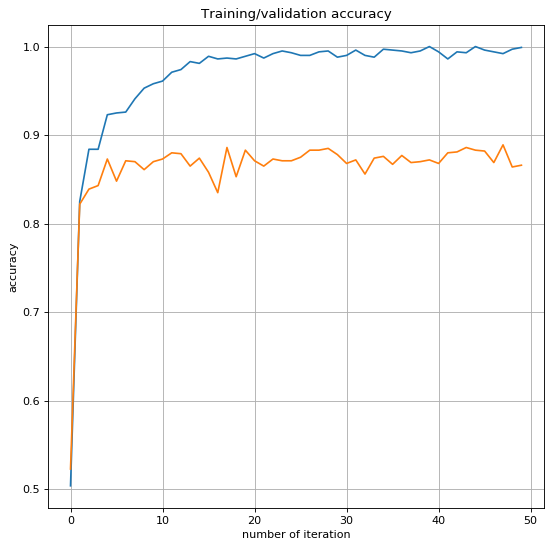

In [317]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# 4 Layer Feed Forward Neural Network

In [318]:

HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS, H = 26, 26, 5, 5000, 100
learning_rate = 0.001
    
model2 = TwoLayerNN(HEIGHT * WIDTH, NUM_CLASSES, 3)
optimizer = torch.optim.Adam(model2.parameters(), lr= learning_rate)
def train(batch_size):
    model2.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model2(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

import random
def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = train_seqs[i].astype(np.float32)
    y = train_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    lst = list(model2.parameters())
        
    for i in range(1000):
        h1 = x[i].dot(lst[0].data.numpy().transpose()) + lst[1].data.numpy()
        h1_relu = np.maximum(0.0, h1)
        h2 = h1_relu.dot(lst[2].data.numpy().transpose()) + lst[3].data.numpy()
        h2_relu = np.maximum(0.0, h2)
        y_pred = h2_relu.dot(lst[4].data.numpy().transpose()) + lst[5].data.numpy()
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    y_hat = np.empty(1000)

    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = val_seqs[i].astype(np.float32)
    y = cv_labels[i].astype(np.int)
    
    
    lst = list(model2.parameters())
    for i in range(1000):
        
        h1 = x[i].dot(lst[0].data.numpy().transpose()) + lst[1].data.numpy()
        h1_relu = np.maximum(0.0, h1)
        h2 = h1_relu.dot(lst[2].data.numpy().transpose()) + lst[3].data.numpy()
        h2_relu = np.maximum(0.0, h2)
        y_pred = h2_relu.dot(lst[4].data.numpy().transpose()) + lst[5].data.numpy()
        res = np.argmax(y_pred)
        y_hat[i] = res
    acc = accuracy(y,y_hat)
    return acc


train_accs, val_accs = [], []
batch_size = 100
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.24  0.27
   100  0.78  0.79
   200  0.81  0.80
   300  0.81  0.80
   400  0.85  0.84
   500  0.85  0.82
   600  0.89  0.85
   700  0.90  0.84
   800  0.87  0.86
   900  0.89  0.83
  1000  0.89  0.85
  1100  0.90  0.86
  1200  0.89  0.88
  1300  0.89  0.86
  1400  0.89  0.87
  1500  0.90  0.84
  1600  0.89  0.86
  1700  0.91  0.86
  1800  0.93  0.86
  1900  0.92  0.85
  2000  0.92  0.85
  2100  0.91  0.88
  2200  0.93  0.85
  2300  0.94  0.88
  2400  0.93  0.86
  2500  0.94  0.88
  2600  0.94  0.84
  2700  0.93  0.85
  2800  0.93  0.86
  2900  0.94  0.86
  3000  0.94  0.88
  3100  0.93  0.87
  3200  0.94  0.86
  3300  0.95  0.87
  3400  0.94  0.86
  3500  0.94  0.85
  3600  0.95  0.88
  3700  0.95  0.85
  3800  0.96  0.85
  3900  0.95  0.88
  4000  0.96  0.85
  4100  0.96  0.86
  4200  0.95  0.85
  4300  0.96  0.86
  4400  0.96  0.85
  4500  0.96  0.87
  4600  0.97  0.88
  4700  0.97  0.87
  4800  0.96  0.86
  4900  0.98  0.88


max_train accuracy:  0.978
max_val accuracy:  0.884


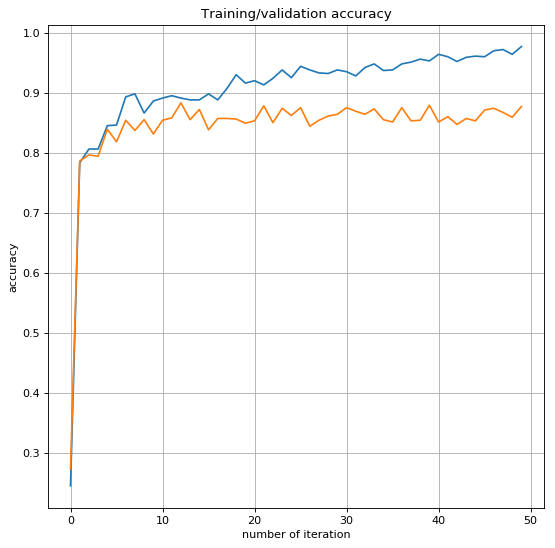

In [319]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Choosing 3 layer (3 hidden layer) Neural Network to implement dropout.

In [321]:

HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS, H = 26, 26, 5, 5000, 300
learning_rate = 0.0001

class FeedForwardNN(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(FeedForwardNN, self).__init__()
        #self.Linear = torch.nn.Linear(D_in, D_out)
        #self.hidden_layer_count = layers
        self.Linear1 = torch.nn.Linear(D_in, H)
        self.drop = torch.nn.Dropout(p=0.5, inplace=False)
        self.middleLinear = torch.nn.Linear(H, H)
        self.Linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h = self.Linear1(x)
        h_relu = F.relu(h, inplace=False)
        #x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        h_middle = self.middleLinear(self.drop(h_relu))
        h_middle_relu = F.relu(h_middle, inplace = False)
        y_pred = self.Linear2(h_middle)
        return y_pred
        
    
model3 = FeedForwardNN(HEIGHT * WIDTH, NUM_CLASSES)
optimizer = torch.optim.Adam(model3.parameters(), lr= learning_rate)
def train(batch_size):
    model3.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model3(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

import random


#approx train accuracy() that extracts 1,000 random training
#instances, creates a single batch with all of these inputs, computes integer predictions
#for each example in the batch, and returns an accuracy by comparing these
#predictions to the ground-truth labels.

def approx_train_accuracy():
    model3.eval()
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    lst = list(model3.parameters())
        
    for i in range(1000):
        res = model3(x[i])
        y_hat[i] = np.argmax(res.data.numpy())
    acc = accuracy(y,y_hat)
    return acc

#val accuracy() that creates a single batch with all validation
#examples, computes integer predictions for each example in the batch, and returns
#an accuracy by comparing these predictions to the ground-truth labels

def val_accuracy():
    model3.eval()
    y_hat = np.empty(1000)

    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    
    lst = list(model3.parameters())
    for i in range(1000):
        
        res = model3(x[i])
        y_hat[i] = np.argmax(res.data.numpy())
    acc = accuracy(y,y_hat)
    return acc

train_accs, val_accs = [], []
batch_size = 100
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.28  0.30
   100  0.73  0.74
   200  0.76  0.79
   300  0.79  0.79
   400  0.80  0.78
   500  0.81  0.80
   600  0.83  0.80
   700  0.82  0.81
   800  0.83  0.81
   900  0.81  0.81
  1000  0.86  0.83
  1100  0.83  0.86
  1200  0.84  0.83
  1300  0.85  0.84
  1400  0.85  0.85
  1500  0.83  0.84
  1600  0.84  0.83
  1700  0.87  0.86
  1800  0.88  0.83
  1900  0.86  0.83
  2000  0.88  0.85
  2100  0.89  0.85
  2200  0.87  0.86
  2300  0.88  0.85
  2400  0.90  0.85
  2500  0.89  0.86
  2600  0.90  0.86
  2700  0.87  0.87
  2800  0.87  0.86
  2900  0.90  0.86
  3000  0.88  0.85
  3100  0.89  0.86
  3200  0.88  0.86
  3300  0.90  0.87
  3400  0.89  0.88
  3500  0.89  0.85
  3600  0.91  0.87
  3700  0.90  0.86
  3800  0.90  0.87
  3900  0.90  0.87
  4000  0.90  0.87
  4100  0.88  0.87
  4200  0.89  0.87
  4300  0.91  0.85
  4400  0.89  0.86
  4500  0.91  0.87
  4600  0.89  0.87
  4700  0.91  0.85
  4800  0.92  0.91
  4900  0.90  0.89


max_train accuracy:  0.915
max_val accuracy:  0.909


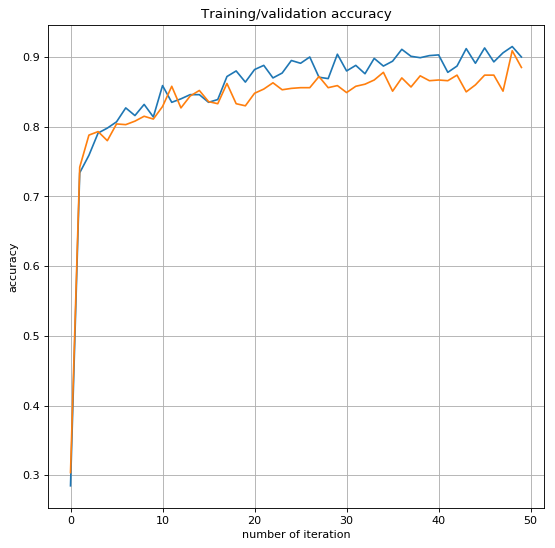

In [322]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# 3 Layer Neural Network with multi class hinge loss

In [325]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS, H = 26, 26, 5, 5000, 300
learning_rate = 0.0001

class FeedForwardNN(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(FeedForwardNN, self).__init__()
        self.Linear1 = torch.nn.Linear(D_in, H)
        self.middleLinear = torch.nn.Linear(H, H)
        self.Linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h = self.Linear1(x)
        h_relu = F.relu(h, inplace=False)
        h_drop = F.dropout(h_relu, training = self.training)
        h_middle = self.middleLinear(h_drop)
        h_middle_relu = F.relu(h_middle, inplace = False)
        y_pred = self.Linear2(h_middle_relu)
        return y_pred
        
    
model3 = FeedForwardNN(HEIGHT * WIDTH, NUM_CLASSES)
optimizer = torch.optim.Adam(model3.parameters(), lr= learning_rate)
def train(batch_size):
    model3.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model3(x)
    loss = F.multi_margin_loss(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

import random
def approx_train_accuracy():
    model3.eval()
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    lst = list(model3.parameters())
        
    for i in range(1000):
        res = model3(x[i])
        y_hat[i] = np.argmax(res.data.numpy())
    acc = accuracy(y,y_hat)
    return acc

def val_accuracy():
    model3.eval()
    y_hat = np.empty(1000)

    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int)
    y_hat = np.empty(1000)
    
    
    lst = list(model3.parameters())
    for i in range(1000):
        
        res = model3(x[i])
        y_hat[i] = np.argmax(res.data.numpy())
    acc = accuracy(y,y_hat)
    return acc


train_accs, val_accs = [], []
batch_size = 200
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        #model3.eval()
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.27  0.28
   100  0.74  0.75
   200  0.77  0.77
   300  0.80  0.79
   400  0.80  0.81
   500  0.80  0.79
   600  0.84  0.81
   700  0.83  0.81
   800  0.84  0.82
   900  0.83  0.83
  1000  0.84  0.82
  1100  0.85  0.81
  1200  0.88  0.84
  1300  0.85  0.83
  1400  0.84  0.84
  1500  0.87  0.85
  1600  0.86  0.83
  1700  0.86  0.84
  1800  0.88  0.85
  1900  0.85  0.87
  2000  0.87  0.85
  2100  0.88  0.85
  2200  0.88  0.86
  2300  0.87  0.86
  2400  0.88  0.84
  2500  0.89  0.85
  2600  0.87  0.87
  2700  0.88  0.88
  2800  0.89  0.86
  2900  0.91  0.85
  3000  0.89  0.86
  3100  0.90  0.87
  3200  0.89  0.88
  3300  0.89  0.88
  3400  0.91  0.87
  3500  0.89  0.87
  3600  0.92  0.86
  3700  0.90  0.86
  3800  0.90  0.89
  3900  0.90  0.86
  4000  0.91  0.88
  4100  0.91  0.86
  4200  0.92  0.88
  4300  0.91  0.89
  4400  0.92  0.86
  4500  0.92  0.86
  4600  0.92  0.87
  4700  0.92  0.88
  4800  0.92  0.88
  4900  0.92  0.88


max_train accuracy:  0.924
max_val accuracy:  0.888


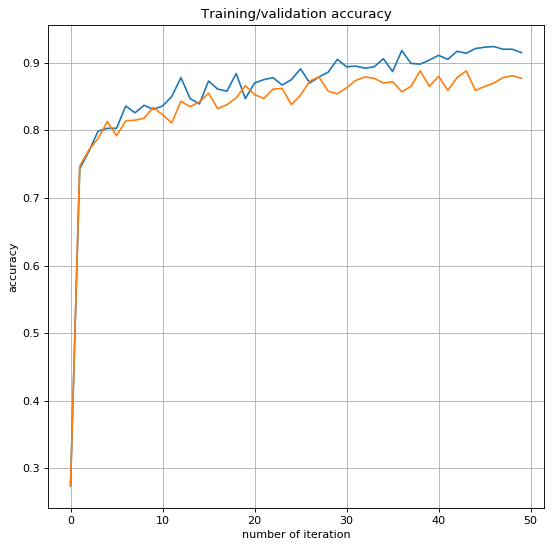

In [326]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()


Best Validation accuracy is achieved using Cross entropy loss and drop out. 
The highest validation accuracy achieved is 90% with significantly reduced overfitting trend.

Batch size = 250
Learning rate = 0.0001
Optimization steps = 5000
time taken < 1 minute